In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from gp_oed_surrogate import create_gp, save_gp, load_gp

In [2]:
# Adjust figure size of plots in this notebook:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)

In [3]:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)

In [4]:
def load_data(data_dir):
    # Import data from text file:
    training_data = np.loadtxt(data_dir)
    # Note that columns of beam data arranged as: [angle, c10, disp]
    # Rearrange to form: [c10, angle, x, y, z, disp]:
    training_data.T[[0,1]] = training_data.T[[1,0]]
    # Convert to Jax.numpy array:
    rows_2_extract = training_data[:,0] > 1.
    x_train = jnp.array(training_data[rows_2_extract,0:-1])
    y_train = jnp.array(training_data[rows_2_extract,-1])
    return (x_train, y_train)

In [5]:
def plot_gp_surface(d_pts, theta_pts, y_pts, train_dict=None):
    # Create surface plot:
    fig, ax = plt.subplots()
    contour_fig = ax.contourf(theta_pts, d_pts, y_pts, cmap='viridis')
    cbar = fig.colorbar(contour_fig)
    ax.set_xlabel('Beam stiffness c10')
    ax.set_ylabel('Angle of Beam in Degrees')
    cbar.set_label('Displacement', rotation=270, labelpad=15)
    if train_dict:
        plt.plot(train_dict['d'], train_dict['theta'], 'x', color='red', markersize=10)
    fig.patch.set_facecolor('white')
    plt.show()

In [6]:
# Load training data:
data_dir = "beam_data_one_pt.txt"
x_train, y_train =  load_data(data_dir)
constraints = {"length_0": {">": 10**-1, "<": 10**3}, 
               "length_1": {">": 10**-1, "<": 10**3}, 
               "const": {">": 10**-1, "<": 10**3}}
# Create surrogate:
surrogate = create_gp(kernel, x_train, y_train, constraints)

36892.074
313.06955
254.67828
254.69019
254.55301
254.46191
254.47672
254.57166
254.46191
254.46191
254.46191
254.46191
254.46191
254.46191
254.46191
254.46191
254.46191
254.46191
      fun: array(254.46191406)
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01533117, -1.28834534, -0.01369363])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 5
     njev: 18
   status: 0
  success: True
        x: array([511.31206354,   0.81637218, 522.21368106])
278690.06
232598.06
323.02042
911.52716
251.35025
250.72678
251.47342
250.45639
251.74823
250.86557
250.36179
250.54294
250.36179
250.36179
250.36179
250.36179
250.36179
250.36179
250.36179
250.36179
      fun: array(250.36178589)
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.00927088e-03,  4.62905884e+00, -8.29845667e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 6
     njev: 20
   status: 0
  success: 

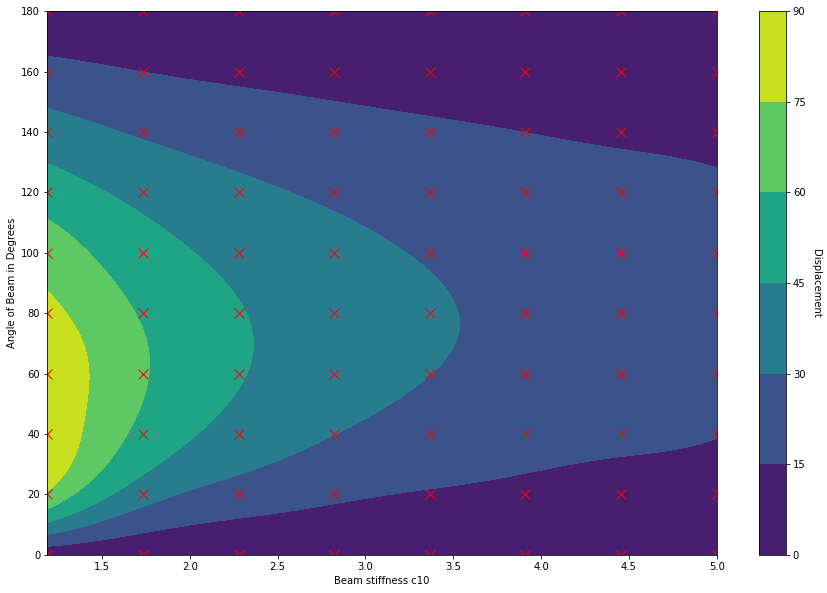

In [9]:
# Plot surrogate model surface:
d_pts = jnp.linspace(jnp.min(x_train[:,1]), jnp.max(x_train[:,1]), 1000)
theta_pts = jnp.linspace(jnp.min(x_train[:,0]), jnp.max(x_train[:,0]), 1000) 
d_grid, theta_grid = jnp.meshgrid(d_pts, theta_pts)
x = jnp.vstack((theta_grid.flatten(), d_grid.flatten())).T
y_pts = surrogate.predict_mean(x)
y_grid_pred = y_pts.reshape(d_pts.size,theta_pts.size)
train_dict = {"theta": x_train[:,1], "d": x_train[:,0]}
plot_gp_surface(d_grid, theta_grid, y_grid_pred, train_dict=train_dict)

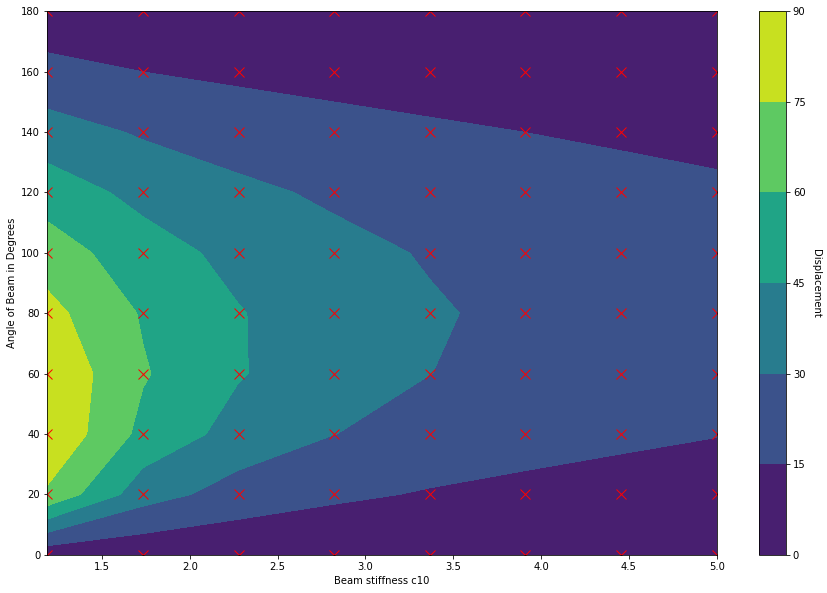

In [10]:
# Plot training data:
d_pts, theta_pts, y_pts = x_train[:,1], x_train[:,0], y_train
d_size, theta_size = len(jnp.unique(x_train[:,1])), len(jnp.unique(x_train[:,0]))
theta_grid, d_grid, y_grid = \
    theta_pts.reshape(d_size,theta_size), d_pts.reshape(d_size,theta_size), y_pts.reshape(d_size,theta_size)  
plot_gp_surface(d_grid, theta_grid, y_grid, train_dict=train_dict)

In [7]:
# Save Gaussian process model - NB: required imports apart from jnp need to be imported INSIDE kernel function:
save_gp(surrogate, "nonlinear_kernel_gp")

In [13]:
# Attempt to reload GP model:
loaded_gp = load_gp("nonlinear_kernel_gp.json")

# Check to make sure predictions are the same as before:
loaded_y_pt = loaded_gp.predict_mean(x)
y_pts = surrogate.predict_mean(x)
print(f"Does loaded_y_pt == y_pt? {jnp.all(loaded_y_pt == y_pts)}")

Does loaded_y_pt == y_pt? True
